In [1]:
from __future__ import print_function

import datetime
import pickle
import warnings

from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import numpy as np
import pandas as pd
import seaborn as sns

import yfinance as yf
import os
# froom pathlib import Path

In [2]:
def obtain_prices_df(csv_filepath, symbol, end_date):
    """
    Obtain the prices DataFrame from the CSV file,
    filter by the end date and calculate the 
    percentage returns.
    """
    full_path = os.path.join(csv_filepath, f'{symbol}.csv')
    print(f' data full path: {full_path}')
    if not os.path.exists(full_path):
        data = yf.download(symbol)
        data.to_csv(full_path)
    df = pd.read_csv(
        full_path, header=0,
        names=[
            "Date", "Open", "High", "Low", 
            "Close", "Volume", "Adj Close"
        ],
        index_col="Date", parse_dates=True
    )
    df["Returns"] = df["Adj Close"].pct_change()
    df = df[:end_date.strftime("%Y-%m-%d")]
    df.dropna(inplace=True)
    return df


In [3]:
def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            df["Adj Close"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()


In [4]:
# Hides deprecation warnings for sklearn
warnings.filterwarnings("ignore")

sym="QQQ"
# Create the SPY dataframe from the Yahoo Finance CSV
# and correctly format the returns for use in the HMM
BASE_DIR = os.getcwd()
# HMM_DIR = os.path.join(BASE_DIR, "HMM")

csv_filepath = os.path.join(BASE_DIR, "data")
MODEL_DIR = os.path.join(BASE_DIR, "model")
print(csv_filepath)
pickle_path = os.path.join(MODEL_DIR, f"{sym}.pkl")
print(pickle_path)
end_date = datetime.datetime(2009, 12, 31)

/home/thomas/projects/Proof-Of-Concept/Quant_Analysis/data
/home/thomas/projects/Proof-Of-Concept/Quant_Analysis/model/QQQ.pkl


 data full path: /home/thomas/projects/Proof-Of-Concept/Quant_Analysis/data/QQQ.csv


[*********************100%%**********************]  1 of 1 completed


Model Score: -865.1680414848337


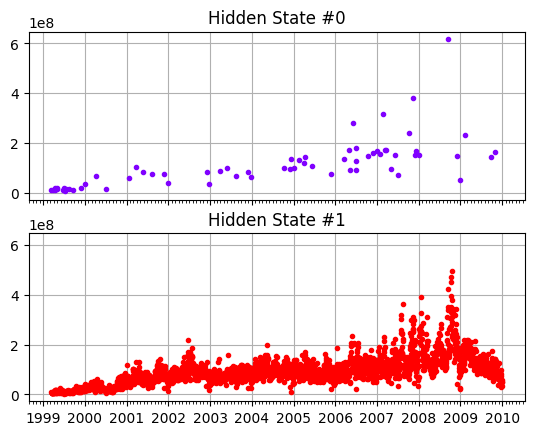

Pickling HMM model...
...HMM model pickled.


In [5]:
data = obtain_prices_df(csv_filepath, sym, end_date)
rets = np.column_stack([data["Returns"]])

# Create the Gaussian Hidden markov Model and fit it
# to the SPY returns data, outputting a score
hmm_model = GaussianHMM(
    n_components=2, covariance_type="full", n_iter=1000
).fit(rets)
print("Model Score:", hmm_model.score(rets))

# Plot the in sample hidden states closing values
plot_in_sample_hidden_states(hmm_model, data)

print("Pickling HMM model...")
pickle.dump(hmm_model, open(pickle_path, "wb"))
print("...HMM model pickled.")
